## Import Libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.5 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 6.6 MB 59.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler
from transformers import BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import trange
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

## Analisis Dataset

In [ ]:
fake_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/input/fake-and-real-news-dataset/Fake.csv")
true_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/input/fake-and-real-news-dataset/True.csv")

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_df["output"] = 0
true_df["output"] = 1

In [ ]:
# news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)

df = fake_df.append(true_df).sample(frac=1).reset_index(drop=True) # shuffle data after append

# check the number of rows and columns in the training set
print("Number of data examples: {} \n".format(df.shape[0]))
print("Number of data columns: {} \n".format(df.shape[1]))

df.head()

Number of data examples: 44898 

Number of data columns: 5 



,title,text,subject,date,output
0,Philippines Duterte says only answers to his p...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"November 14, 2017",1
1,Detroit mayor eyes legal action over pension s...,DETROIT (Reuters) - Detroit may sue some of th...,politicsNews,"February 24, 2016",1
2,WATCH: GOP Rep. Steve King Just Dropped A BOM...,"Oh, the wiretapping scandal. Or it would be a ...",News,"March 11, 2017",0
3,EXPOSE THE LIES: Shut Down Planned Parenthood’...,TODAY IS SCHEDULE YOUR MAMMOGRAM DAY WITH PL...,left-news,"Sep 21, 2015",0
4,Right-Wing Broadcaster: Teenage Girl Is A ‘Pr...,We recently saw the heartbreaking plea of 15-y...,News,"January 13, 2016",0


### Temukan nilai yang hilang dan drop baris yang sesuai

In [ ]:
# print out stats about data 

# replace empty strings with nan type
# df["title"].replace(" ", np.nan, inplace=True)
# df["text"].replace(" ", np.nan, inplace=True)

missing_values_count = df.isnull().sum() # jumlah data yang hilang per kolom
print("Number of missing data points per column:\n")
print (missing_values_count)

df.dropna(inplace=True) # drop the empty rows

Number of missing data points per column:

title      0
text       0
subject    0
date       0
output     0
dtype: int64


In [ ]:
df.subject.value_counts(normalize=True)

politicsNews       0.251058
worldnews          0.225957
News               0.201568
politics           0.152368
left-news          0.099314
Government News    0.034968
US_News            0.017440
Middle-east        0.017328
Name: subject, dtype: float64

In [ ]:
# Hitung jumlah subjek per output class
info_per_class = df.groupby(["output", "subject"]).size()
print (info_per_class)

output  subject        
0       Government News     1570
        Middle-east          778
        News                9050
        US_News              783
        left-news           4459
        politics            6841
1       politicsNews       11272
        worldnews          10145
dtype: int64


### Visualisasi Dataset

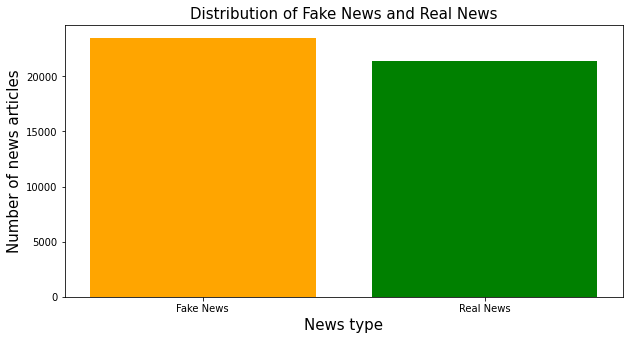

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(true_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News type', size=15)
plt.ylabel('Number of news articles', size=15)
plt.show()

In [ ]:
df["title_length"] = df["title"].apply(lambda x: len(x.split()))
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
df.describe()

,output,title_length,text_length
count,44881.000000,44881.000000,44881.000000
mean,0.476816,12.453288,405.290658
std,0.499468,4.112149,351.331820
min,0.000000,1.000000,0.000000
25%,0.000000,10.000000,203.000000
50%,0.000000,11.000000,362.000000
75%,1.000000,14.000000,513.000000
max,1.000000,42.000000,8135.000000


**Visualisasi histogram distribusi panjang judul**

Text(0, 0.5, 'Count')

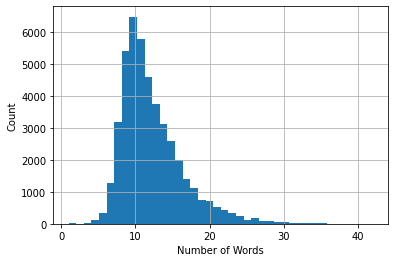

In [ ]:
df["title_length"].hist(bins=40)
plt.xlabel("Number of Words")
plt.ylabel("Count")

### Data Duplikat

In [ ]:
df["is_duplicate"] = df.duplicated()
df[df["is_duplicate"]==True].count() 

title           209
text            209
subject         209
date            209
output          209
is_duplicate    209
dtype: int64

In [ ]:
df.drop_duplicates(keep=False, inplace=True, ignore_index=True)
df.drop("is_duplicate", axis=1, inplace=True) 
print("Number of data examples after dropping duplicates: {} \n".format(df.shape[0]))

Number of data examples after dropping duplicates: 44881 



## Train Validation Test Split

In [ ]:
train_df, sub_df = train_test_split(df, stratify=df.output.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

validation_df, test_df = train_test_split(sub_df, stratify=sub_df.output.values, 
                                                  random_state=42, 
                                                  test_size=0.25, shuffle=True)


train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
# Periksa jumlah examples setelah split
print("Train data: {} \n".format(train_df.shape))
print("Validation data: {} \n".format(validation_df.shape))
print("Test data: {} \n".format(test_df.shape))

Train data: (35904, 5) 

Validation data: (6732, 5) 

Test data: (2245, 5) 



## Process and Load the Data

**Initialize the tokenizer**

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

# model_name = "distilbert-base-uncased" #Faster
# tokenizer = DistilBertTokenizer.from_pretrained(model_name, do_lower_case=True)

tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

String judul artikel akan dimasukkan sebagai masukan ke model. Karena urutan judul memiliki panjang yang bervariasi, urutan input diisi dengan panjang yang tetap. Dari histogram di atas untuk distribusi panjang judul, terlihat bahwa sebagian besar judul tidak lebih dari 30 kata. Oleh karena itu MAX_LEN diatur ke 30 untuk memastikan tidak terlalu banyak informasi yang hilang

In [ ]:
# Configuration Settings
NUM_LABELS = 2
BATCH_SIZE = 32
MAX_LEN = 30
EPOCHS = 3
LEARNING_RATE = 1e-5

Persiapan data mencakup langkah-langkah prapemrosesan seperti menurunkan huruf besar-kecil pada string judul, menerapkan tokenisasi dan vektorisasi untuk memasukkan data numerik ke model pembelajaran mesin. Contoh-contoh tersebut kemudian diumpankan sebagai batch selama fase pelatihan.

In [ ]:
def process_data(df, tokenizer, max_len=30):
    """
    Process the data to feed into the pretrained model
    """
    data_processed = tokenizer.batch_encode_plus(df.title.values, padding=True, truncation=True, add_special_tokens=True, return_attention_mask=True, max_length=max_len, return_tensors='pt')
    input_ids_train = data_processed["input_ids"]
    attention_mask_train = data_processed["attention_mask"]
    output_train = torch.tensor(df.output.values)
    return input_ids_train, attention_mask_train, output_train

input_ids_train, attention_mask_train, output_train = process_data(train_df, tokenizer, max_len=MAX_LEN)
input_ids_val, attention_mask_val, output_val = process_data(validation_df, tokenizer, max_len=MAX_LEN)
input_ids_test, attention_mask_test, output_test = process_data(test_df, tokenizer, max_len=MAX_LEN)

In [ ]:
def load_data(seq, mask, output, batch_size=32, use_train=True):
    """
    Load data into batches
    """
    data = TensorDataset(seq, mask, output)
    if use_train: sampler = RandomSampler(data)
    else: sampler = SequentialSampler(data)
    dl_data = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dl_data

dl_train = load_data(input_ids_train, attention_mask_train, output_train, batch_size=BATCH_SIZE)
dl_val = load_data(input_ids_val, attention_mask_val, output_val, batch_size=BATCH_SIZE, use_train=False)

## Build and Train the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #train on gpu if available
print("Using device {}.\n".format(device))
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, output_hidden_states=False, output_attentions=False)
# model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, output_hidden_states=False, output_attentions=False)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)  # Default optimization
# Learning rate scheduling is applied after optimizer’s update to adjust the learning rate based on the number of epochs.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dl_train) * EPOCHS) #number of batches * number of epochs
# print(model)

Using device cuda.



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def count_parameters(model):
    ''' Count the total number of trainable parameters '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print("The model has total {} trainable parameters".format(num_params))

The model has total 109483778 trainable parameters


In [ ]:
def eval_metric(predictions, labels):
  ''' Calculate average accuracy of the data samples '''
  max_predictions = predictions.argmax(axis=1, keepdim=True) #[batch_size]
  avg_acc = round(accuracy_score(y_true=labels.to('cpu').tolist(), y_pred=max_predictions.detach().cpu().numpy()), 2)*100 
  return avg_acc

In [ ]:
def train_fn(model, train_loader, optimizer, device, scheduler, criterion=None):
  ''' Define the training function '''
  model.train() #set the model on train mode
  total_loss, total_acc = 0, 0

  for batch in train_loader:
    batch = tuple(item.to(device) for item in batch)
    input_ids, input_mask, labels = batch
    optimizer.zero_grad() # clear gradients from last batch
    outputs = model(input_ids, attention_mask=input_mask, labels=labels) # get predictions
#     loss = criterion(batch_y_pred, batch_y) # compute the loss
    loss = outputs.loss
    total_loss += loss.item() #aggregate the losses
    loss.backward() # compute the gradients
    optimizer.step() # update the parameters
    scheduler.step()
    logits = outputs.logits
    total_acc += eval_metric(logits, labels)

  loss_per_epoch = total_loss/len(train_loader)
  acc_per_epoch = total_acc/len(train_loader)
  return loss_per_epoch, acc_per_epoch



def eval_fn(model, data_loader, device, criterion=None):
  ''' Define the evaluation function '''
  model.eval() # set the model on eval mode
  total_loss, total_acc = 0, 0

  with torch.no_grad(): # do not need to update the parameters
    for batch in data_loader:
      batch = tuple(item.to(device) for item in batch)
      input_ids, input_mask, labels = batch
      outputs = model(input_ids, attention_mask=input_mask, labels=labels) # get predictions
#       loss = criterion(batch_y_pred, batch_y) # compute the loss
      loss = outputs.loss
      total_loss += loss.item() #aggregate the losses
      logits = outputs.logits
      total_acc += eval_metric(logits, labels)

  loss_per_epoch = total_loss/len(data_loader)
  acc_per_epoch = total_acc/len(data_loader)
  return loss_per_epoch, acc_per_epoch

**Sempurnakan model yang telah dilatih sebelumnya pada data pelatihan dan evaluasi kinerja model pada data validasi untuk sejumlah epoch**

In [ ]:
# Training

train_losses, validation_losses = [], [] # Store train and validation losses for plotting
train_accuracies, validation_accuracies = [], []
best_val_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epoch"):
  train_loss_per_epoch, train_acc_per_epoch = train_fn(model, dl_train, optimizer, device, scheduler)
  val_loss_per_epoch, val_acc_per_epoch = eval_fn(model, dl_val, device)

  train_losses.append(train_loss_per_epoch)
  validation_losses.append(val_loss_per_epoch)
  train_accuracies.append(train_acc_per_epoch)
  validation_accuracies.append(val_acc_per_epoch)

  if val_loss_per_epoch < best_val_loss:
    best_val_loss = val_loss_per_epoch
    torch.save(model.state_dict(), 'model.pt')
    
  print("Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(epoch, train_loss_per_epoch, train_acc_per_epoch))
  print("Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%\n".format(epoch, val_loss_per_epoch, val_acc_per_epoch))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.0957, Train Accuracy: 96.90%
Epoch: 0, Validation Loss: 0.0485, Validation Accuracy: 98.25%

Epoch: 1, Train Loss: 0.0317, Train Accuracy: 98.99%
Epoch: 1, Validation Loss: 0.0417, Validation Accuracy: 98.41%

Epoch: 2, Train Loss: 0.0169, Train Accuracy: 99.50%
Epoch: 2, Validation Loss: 0.0433, Validation Accuracy: 98.62%



## Evaluate Model on Test Data

In [ ]:
# Test

# Load the best training model
print("Loading the best trained model")
model.load_state_dict(torch.load('model.pt'))

with torch.no_grad():
  input_ids_test = input_ids_test.to(device)
  attention_mask_test = attention_mask_test.to(device)
  outputs = model(input_ids_test, attention_mask_test)
  logits = outputs.logits #output[0] #[batch_size, num_classes]
  batch_logits = logits.detach().cpu().numpy() #shape: [batch_size, num_classes]  
  preds = np.argmax(batch_logits, axis=1)
    
print(classification_report(output_test, preds))
print("ROC AUC Score: {}".format(roc_auc_score(y_true=output_test, y_score=preds)))

Loading the best trained model
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1175
           1       0.98      0.99      0.99      1070

    accuracy                           0.99      2245
   macro avg       0.99      0.99      0.99      2245
weighted avg       0.99      0.99      0.99      2245

ROC AUC Score: 0.9881348180552794


## Generate the ROC Curve

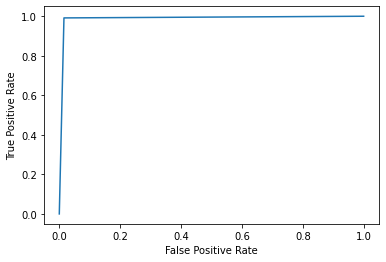

In [ ]:
# Plot the ROC Curve
fpr, tpr, _ = metrics.roc_curve(output_test,  preds)

# Create ROC Curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Plot the Confusion Matrix

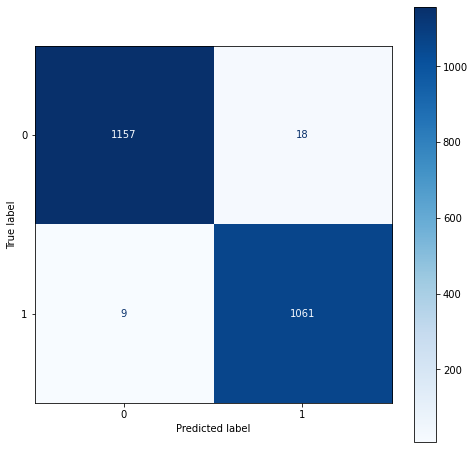

In [ ]:
def plot(predictions, labels):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, predictions)
  cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
  cm.plot(values_format='d', cmap='Blues', ax=ax)

plot(preds, output_test)

## Beberapa Prediksi yang Salah pada Test Data

In [ ]:
prediksi = test_df.copy()
prediksi['prediction'] = preds
# prediksi.drop(["title_length", "text_length"], axis=1, inplace=True)

Beberapa prediksi yang salah yang dibuat oleh model yang dipelajari di set tes

**Artikel yang benar tetapi diprediksi palsu:**

In [ ]:
temp_df = prediksi[(prediksi["output"]==1) & (prediksi["prediction"]==0)]
temp_df.reset_index(drop=True, inplace=True)
temp_df

,title,text,subject,date,output,prediction
0,Toxic algae and ice cream party keep top Repub...,CLEVELAND (Reuters) - As Republicans spilled i...,politicsNews,"July 18, 2016",1,0
1,How a businessman struck a deal with Islamic S...,RAQQA/DUBAI (Reuters) - While Syrian President...,worldnews,"October 11, 2017",1,0
2,"FCC chairman to step down, handing GOP a majority",WASHINGTON (Reuters) - U.S. Federal Communicat...,politicsNews,"December 15, 2016",1,0
3,"An Obama, not the president, brings down the h...",PHILADELPHIA (Reuters) - Democrats divided ove...,politicsNews,"July 26, 2016",1,0
4,Latest Hillary Clinton bio for kids highlights...,"POTOMAC, Md. (Reuters) - As Hillary Clinton se...",politicsNews,"March 4, 2016",1,0
5,Elections get dirty as adult filmmakers set up...,"SACRAMENTO, Calif. (Reuters) - California poli...",politicsNews,"April 28, 2016",1,0
6,Oops! Senator's article tells of phantom meeti...,WASHINGTON (Reuters) - Republican U.S. Senator...,politicsNews,"May 26, 2016",1,0
7,Scalise in critical condition after attack by ...,"ALEXANDRIA, Va. (Reuters) - Congressman Steve ...",politicsNews,"June 14, 2017",1,0
8,Pro-Trump groups take no prisoners in rush to ...,"WASHINGTON (Reuters) - Flush with cash, politi...",politicsNews,"June 28, 2017",1,0


**Artikel yang palsu tetapi diprediksi sebagai benar:**

In [ ]:
temp_df = prediksi[(prediksi["output"]==0) & (prediksi["prediction"]==1)]
temp_df.reset_index(drop=True, inplace=True)
temp_df

,title,text,subject,date,output,prediction
0,Trump Used Foundation Donations To Pay Off An...,"Another day, another real Trump controversy. W...",News,"September 20, 2016",0,1
1,Sanders Campaign Begins To Raise Money For Do...,After months of criticism from the Clinton cam...,News,"April 13, 2016",0,1
2,NEW ORLEANS Bans Incredible Civil War Monuments,We ve been following this push to remove all s...,Government News,"Dec 18, 2015",0,1
3,Delegate Plan To Block Trump Is Concrete And ...,"For the last few weeks, rumors have been swirl...",News,"June 24, 2016",0,1
4,THE FUTURE Of The Democratic Party In One Picture,Confusing different policies and different ide...,politics,"Apr 1, 2017",0,1
5,Trump Emboldens Ohio Republicans To Ban Abort...,Donald Trump has not even taken office yet and...,News,"December 7, 2016",0,1
6,Racism Wins The Day As S.C. Prepares To Vote ...,The New York Times reports that Donald Trump i...,News,"February 19, 2016",0,1
7,Socialist Utopia of Venezuela Tells People to ...,"GENERALLY, VENEZUELANS DO NOT EAT RABBITS AND...",Government News,"Sep 16, 2017",0,1
8,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0,1
9,VICTORY: Supreme Court Saves Affirmative Action,"Another day, another time the Supreme Court su...",News,"June 23, 2016",0,1
